# Graphical models in Python : basics tutorial

## BdM lab
### June 2021
-----------

# Import packages

In [21]:
import pymc3 as pm
import theano.tensor as tt
import theano as theano
import arviz as az
# --------------------
# extras for analysis
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from scipy import stats
import seaborn as sns
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # 
from matplotlib import cm
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("ignore")

In [22]:
def z_score1(data_all,z_score_var, part_def = 0):
    z_matrix=[]
    z_matrix_aux=[]
    
    if part_def==0:
        z_matrix = (data_all[z_score_var] - data_all[z_score_var].mean())/ data_all[z_score_var].std()
    else:
        for i in (data_all[part_def].unique()):
            Choicedata = data_all.loc[data_all[part_def] == i]    
        
            pX_A= pd.to_numeric(Choicedata[z_score_var]) 
            pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)
    
            z_matrix_aux= pX_zA.values
        
            for  j in range(len(z_matrix_aux)):    
                z_matrix.append(z_matrix_aux[j])
    return z_matrix

---------------------
--------------------

 ## Load dataset 

In [23]:
data_all = pd.read_csv('data/DataFoodFramingNotebook_31.csv') 
# restart number of participants to make it sequencial (for )
data_all['Part'] = data_all['Part'].replace(data_all.Part.unique(), list(range(len(data_all.Part.unique()))))
# choose only like trials
data_part_all =  data_all.loc[data_all.BlockCond == 1] 

### Extract relevant variables

In [24]:
data_part_all.columns

Index(['Unnamed: 0', 'Part', 'TrialN', 'PairID', 'LItem', 'LValue', 'RItem',
       'RValue', 'ChosenITM', 'ChoiceRT', 'Conf', 'ConfRT', 'BlockCond',
       'tDDT', 'lIA_DT', 'rIA_DT', 'tGSF', 'lastFixat', 'DV', 'zDV', 'absDV',
       'zAbsDV', 'zConf', 'zChoiceRT', 'DFam', 'LFam', 'RFam', 'TotFam',
       'TotVal', 'FamCh', 'FamUnCh', 'ValCh', 'ValUnCh', 'Correct',
       'LValConfBDM', 'LFamConfBDM', 'RValConfBDM', 'RFamConfBDM', 'zDFam',
       'zTotFam', 'zTotVal', 'zValCh', 'zValUnCh', 'zFamCh', 'zFamUnCh',
       'zGSF', 'zDDT', 'absDDT', 'zAbsDFam', 'zLValue', 'zRValue', 'zLFam',
       'zRFam', 'zLValConfBDM', 'zLFamConfBDM', 'zRValConfBDM', 'zRFamConfBDM',
       'ConfSplit', 'GSFMedSplit', 'DDTMedSplit'],
      dtype='object')

In [25]:
# z-score values
data_part_all['zLValue'] = z_score1(data_part_all,'LValue', 'Part')
data_part_all['zRValue'] = z_score1(data_part_all,'RValue', 'Part')
data_part_all['zAbsDVal'] = z_score1(data_part_all,'absDV', 'Part')
data_part_all['zConf'] = z_score1(data_part_all,'Conf', 'Part')
data_part_all['zRT'] = z_score1(data_part_all,'ChoiceRT', 'Part')
data_part_all['zTotVal'] = z_score1(data_part_all,'TotVal', 'Part')

In [26]:
# load input for models
val_a = data_part_all.zLValue.values
val_b = data_part_all.zRValue.values
absDVal = data_part_all.zAbsDVal.values
totVal = data_part_all.zTotVal.values
chosenByPart = data_part_all.ChosenITM.values
rtByPart = data_part_all.zRT.values
confByPart = data_part_all.zConf.values

# 1. Model GLM: confidence ~rt

## generate graphical representation

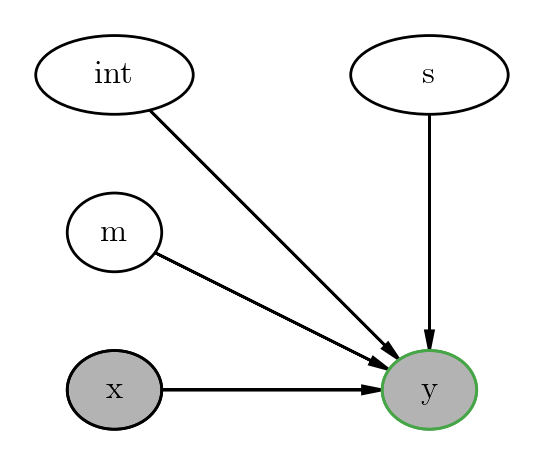

In [103]:
import daft
from matplotlib imgraport rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("sigma", r"s", 5, 2, aspect=2)
pgm.add_node("intercept", r"int", 3, 2, aspect=2)
pgm.add_node("x", r"x", 3, 0, aspect=1.2,observed = True)
pgm.add_node("m", r"m", 3, 1, aspect=1.2)

pgm.add_node("y", r"y", 5, 0, aspect=1.2,observed = True, plot_params=s_color)

# add edges to the graphical model 
pgm.add_edge("sigma", "y", xoffset=-0.1)
pgm.add_edge("intercept", "y", xoffset=-0.1)
pgm.add_edge("m", "y", xoffset=-0.1)
pgm.add_edge("x", "y", xoffset=-0.1)

pgm.render(dpi = 200)
#pgm.savefig("XX.pdf")
#pgm.savefig("PEB_BasicModel_2GenVariance_choice_new.png", dpi=200)


In [28]:
# help(pm.HalfCauchy)

## example: check the priors

In [167]:
with pm.Model() as model00:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    b = pm.Normal("b", 0, sigma=20)


Text(0.5, 1.0, 'Prior distribution for b')

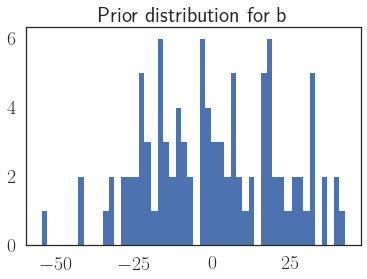

In [169]:
samplesPrior = b.random(size=100)
plt.hist(samplesPrior, bins=50, histtype="stepfilled")
plt.title("Prior distribution for b")
#plt.title("Prior distribution for $\sigma$")

# define the model

In [110]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtByPart, sigma=sigma, observed=confByPart)

    # Inference!
    start = pm.find_MAP() # use maximum a posteriori as starting point
    chains = 5

    trace = pm.sample(3000, cores=2,chains = chains, start = start)  # draw 3000 posterior samples using NUTS sampling
    burned_trace = trace[1000::2] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (5 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 5 chains for 1_000 tune and 3_000 draw iterations (5_000 + 15_000 draws total) took 8 seconds.


# analyze trace

<Figure size 504x504 with 0 Axes>

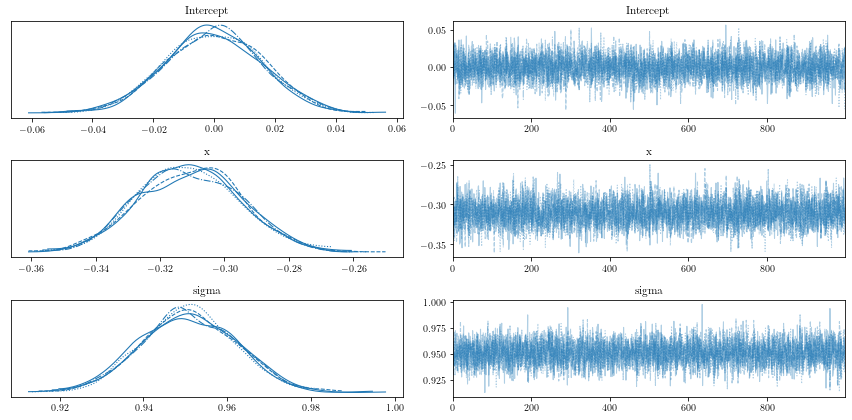

In [111]:
plt.figure(figsize=(7, 7))
pm.traceplot(burned_trace)
plt.tight_layout();

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc2e95c780>],
      dtype=object)

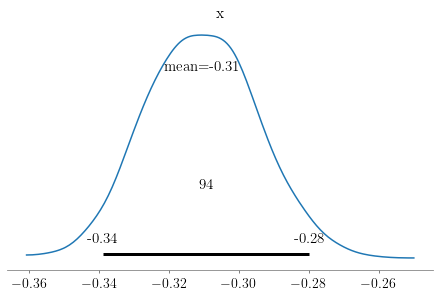

In [112]:
pm.plots.plot_posterior(burned_trace["x"])

In [113]:
rhats_params = az.rhat(burned_trace, method="folded")
rhats_params

<xarray.Dataset>
Dimensions:    ()
Data variables:
    Intercept  float64 1.0
    x          float64 1.001
    sigma      float64 1.0

## check convergence: rhat<1.05 indicates good convergence

In [114]:
az.summary(burned_trace, round_to=5)  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.00013,0.01570,-0.02979,0.02850,0.00023,0.00018,4802.91391,3912.93425,4801.46166,4708.57653,1.00024
x,-0.31067,0.01589,-0.33902,-0.27998,0.00023,0.00016,4698.39215,4690.86205,4693.33591,4358.44952,1.00051
sigma,0.95086,0.01121,0.93105,0.97244,0.00016,0.00011,4932.08223,4930.98595,4916.51569,4752.23155,1.00048


## check autocorrelation

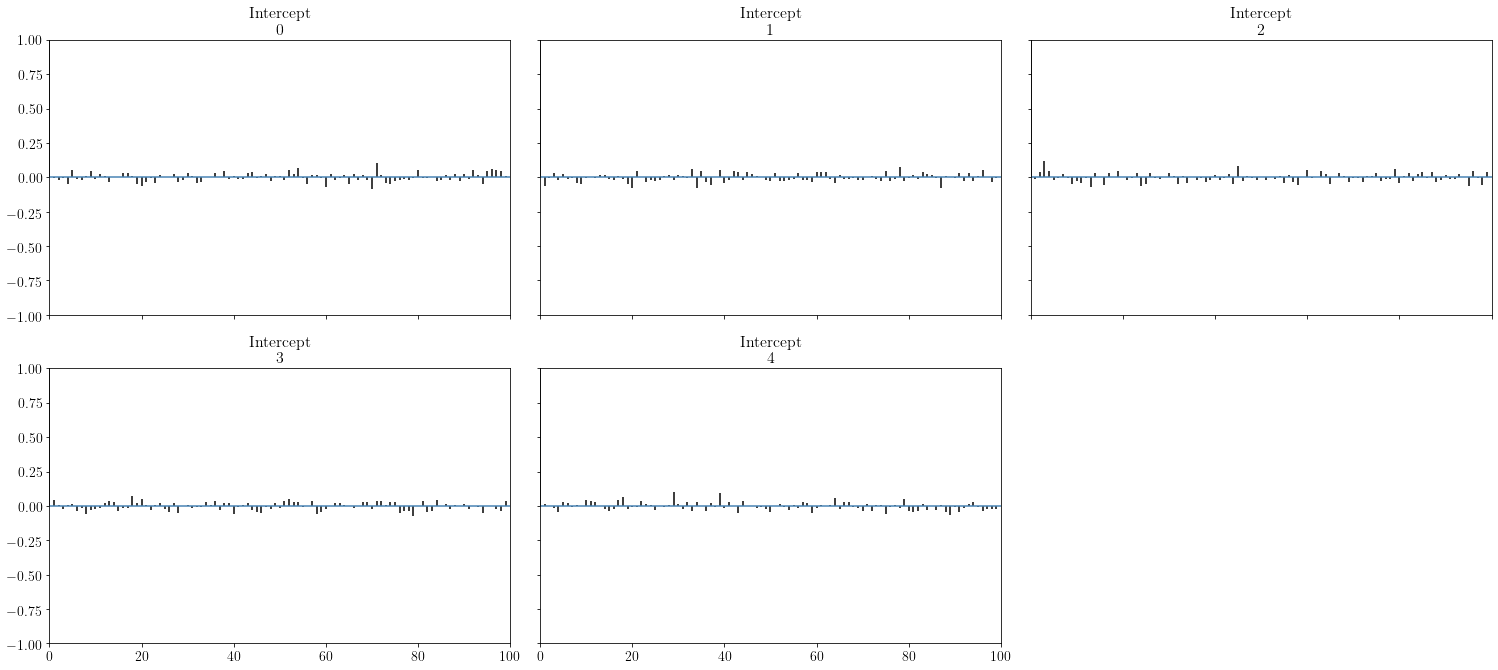

In [115]:
pm.plots.autocorrplot(burned_trace, varnames=["Intercept"]);

## model estimators (for model selection)

In [116]:
pm.waic(burned_trace)
waic1 = pm.waic(burned_trace)

In [117]:
pm.loo(burned_trace)

Computed from 5000 by 3720 log-likelihood matrix

         Estimate       SE
elpd_loo -5093.41    59.04
p_loo        4.73        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [162]:
ppc = pm.sample_posterior_predictive(burned_trace, samples=2000, model=model,var_names = ['x','y','Intercept','sigma'])              #var_names = ['choice]) 

In [163]:
ppc

{'x': array([-0.30090194, -0.31883691, -0.31580052, ..., -0.30508129,
        -0.33661279, -0.31212095]),
 'y': array([[ 0.97891738,  0.50188281,  1.39179585, ..., -0.26147405,
          0.33307969,  0.65064054],
        [ 0.54782617,  1.1770781 ,  1.76527633, ...,  0.64603582,
         -0.49888081,  1.28740954],
        [-0.3907459 , -0.67620952,  0.13213064, ...,  1.07901032,
         -0.39041984,  0.113891  ],
        ...,
        [ 1.32754579, -1.37208438, -0.07768309, ..., -1.94564664,
          1.27590222, -0.8135277 ],
        [-0.6624243 , -0.77630425,  0.66511786, ..., -1.08394926,
         -0.29128063,  0.35577153],
        [ 0.08108788,  1.37719194, -1.37994752, ..., -0.36861121,
         -1.53210666,  0.52117722]]),
 'Intercept': array([ 0.01392064, -0.01352513, -0.00213108, ..., -0.02411486,
        -0.05535002,  0.02233695]),
 'sigma': array([0.9589113 , 0.95815685, 0.95001364, ..., 0.93169805, 0.94706284,
        0.95223403])}

# show data vs posterior samples

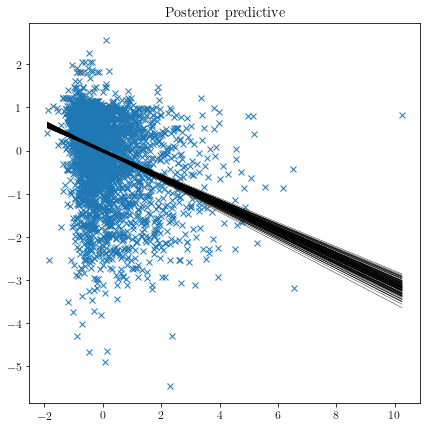

In [64]:
plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
pm.plot_posterior_predictive_glm(burned_trace, samples=100,eval=rtByPart, label="posterior predictive regression lines")
#plt.plot(rtByPart, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

 ------------------

## 2. Using "simple" GLM definition in PyMC3


In [69]:
df1 = pd.DataFrame()
df1['rt'] =rtByPart
df1['conf'] = confByPart

In [70]:
with pm.Model() as model2:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula("conf ~ rt", df1)
    step = pm.Metropolis()
    trace2 = pm.sample(3000, step =step)  # draw 3000 posterior samples using NUTS sampling
    burned_trace2 = trace2[1000::2] 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [rt]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [71]:
az.summary(burned_trace2, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.000,0.015,-0.026,0.031,0.001,0.0,814.795,701.717,809.915,1002.762,1.013
rt,-0.311,0.016,-0.340,-0.279,0.001,0.0,873.628,859.603,885.135,920.569,1.006
sd,0.951,0.011,0.930,0.972,0.000,0.0,936.350,934.579,954.957,864.791,1.007


In [72]:
pm.waic(burned_trace2)


Computed from 4000 by 3720 log-likelihood matrix

          Estimate       SE
elpd_waic -5093.40    59.04
p_waic        4.72        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [73]:
waic2 = pm.waic(burned_trace2)

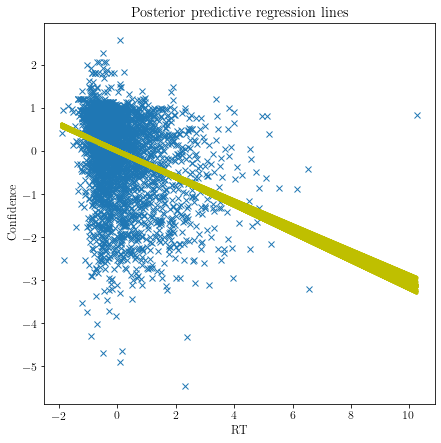

In [74]:
ppc = pm.sample_posterior_predictive(burned_trace2, samples=50, model=model2,var_names = ['Intercept','rt','Intercept','sd'])              #var_names = ['choice]) 

plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
#pm.plot_posterior_predictive_glm(trace2, samples=100, label="posterior predictive regression lines")
for i in range(len(ppc['rt'])):
    plt.plot(rtByPart, ppc['rt'][i]*rtByPart + ppc['Intercept'][i] , label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
#plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

# 3.Simulations/Prediction

In [152]:
ppc = pm.sample_posterior_predictive(burned_trace, samples=2000, model=model,var_names = ['x','Intercept','sigma'])              #var_names = ['choice]) 

In [153]:
ppc

{'x': array([-0.30090194, -0.31883691, -0.31580052, ..., -0.30508129,
        -0.33661279, -0.31212095]),
 'Intercept': array([ 0.01392064, -0.01352513, -0.00213108, ..., -0.02411486,
        -0.05535002,  0.02233695]),
 'sigma': array([0.9589113 , 0.95815685, 0.95001364, ..., 0.93169805, 0.94706284,
        0.95223403])}

In [76]:
sim_Inter = ppc['Intercept'].mean()
sim_sigma = ppc['sigma'].mean()
sim_x = ppc['x'].mean()

print('Simulated Inter:' + str(sim_Inter))
print('Simulated s:' + str(sim_sigma))
print('Simulated x:' + str(sim_x))


Simulated Inter:-8.638094066080889e-06
Simulated s:0.9510210987448875
Simulated x:-0.3114209182684239


## Using same rt than in training

In [77]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define parameters for the simulation
    sigma = sim_sigma
    intercept = sim_Inter
    x_coeff = sim_x

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtByPart, sigma=sigma, shape = len(rtByPart))

    # sample without fixing observed data
    trace = pm.sample(500, cores=2)  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


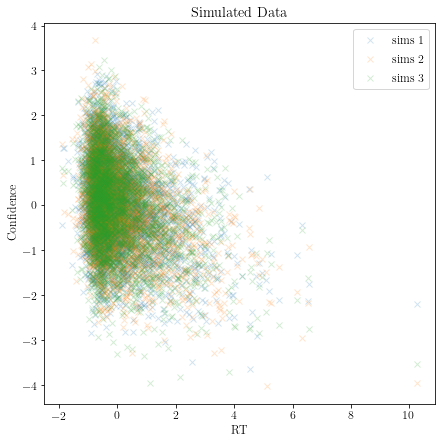

In [78]:
plt.figure(figsize=(7, 7))
plt.plot(rtByPart, trace['y'][0] ,'x' , label="sims 1", alpha = 0.2)
plt.plot(rtByPart, trace['y'][1] ,'x' , label="sims 2", alpha = 0.2)
plt.plot(rtByPart, trace['y'][2] ,'x' , label="sims 3", alpha = 0.2)


plt.legend(loc=0)
plt.title("Simulated Data")
plt.xlabel("RT")
plt.ylabel("Confidence");

## Generating random rt 

In [79]:
rtSims = np.random.uniform(low=-4, high=6, size=(1000))

In [80]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define parameters for the simulation
    sigma = sim_sigma
    intercept = sim_Inter
    x_coeff = sim_x

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * rtSims, sigma=sigma, shape = len(rtSims))

    # Inference!
    trace = pm.sample(500, cores=2)  # draw 3000 posterior samples using NUTS sampling
    #burned_trace = trace[1000::2] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2 seconds.


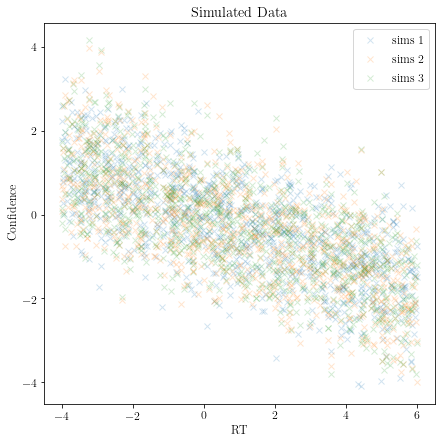

In [81]:
plt.figure(figsize=(7, 7))
plt.plot(rtSims, trace['y'][0] ,'x' , label="sims 1", alpha = 0.2)
plt.plot(rtSims, trace['y'][1] ,'x' , label="sims 2", alpha = 0.2)
plt.plot(rtSims, trace['y'][2] ,'x' , label="sims 3", alpha = 0.2)

plt.legend(loc=0)
plt.title("Simulated Data")
plt.xlabel("RT")
plt.ylabel("Confidence");

-----------------------

# 4. defining a hierarchical GLM

In [119]:
part_names = data_part_all.Part.unique()
part_idx = data_part_all.Part.values
part_idx = part_idx.astype(int)
n_part = len(data_part_all.Part.unique())

In [120]:
part_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [121]:
part_idx

array([ 0,  0,  0, ..., 30, 30, 30])

In [122]:
part_idx

array([ 0,  0,  0, ..., 30, 30, 30])

In [123]:
n_part

31

In [124]:
len(rtByPart)

3720

In [125]:
len(part_idx)

3720

In [126]:
len(confByPart)

3720

In [127]:
part_idx

array([ 0,  0,  0, ..., 30, 30, 30])

## model figure

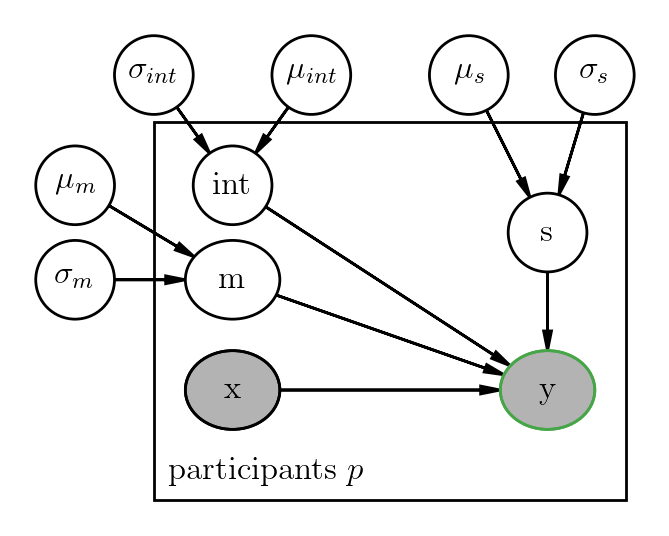

In [128]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("mu_sigma", r"$\mu_s$", 4.5, 3, aspect=1)
pgm.add_node("sd_sigma", r"$\sigma_s$", 5.3, 3, aspect=1)

pgm.add_node("mu_intercept", r"$\mu_{int}$", 3.5, 3, aspect=1)
pgm.add_node("sd_intercept", r"$\sigma_{int}$", 2.5, 3, aspect=1)

pgm.add_node("mu_m", r"$\mu_{m}$", 2, 2.3, aspect=1)
pgm.add_node("sd_m", r"$\sigma_{m}$", 2, 1.7, aspect=1)

pgm.add_node("m", r"m", 3, 1.7, aspect=1.2)
pgm.add_node("sigma", r"s", 5, 2, aspect=1)
pgm.add_node("intercept", r"int", 3, 2.3, aspect=1)
pgm.add_node("x", r"x", 3, 1, aspect=1.2,observed = True)

pgm.add_node("y", r"y", 5, 1, aspect=1.2,observed = True, plot_params=s_color)

# add edges to the graphical model 
pgm.add_edge("m", "y", xoffset=-0.1)

pgm.add_edge('mu_m',"m", xoffset=-0.1)
pgm.add_edge('sd_m',"m", xoffset=-0.1)

pgm.add_edge('mu_sigma',"sigma", xoffset=-0.1)
pgm.add_edge('sd_sigma',"sigma", xoffset=-0.1)

pgm.add_edge('mu_intercept',"intercept", xoffset=-0.1)
pgm.add_edge('sd_intercept',"intercept", xoffset=-0.1)

pgm.add_edge("sigma", "y", xoffset=-0.1)
pgm.add_edge("intercept", "y", xoffset=-0.1)
pgm.add_edge("x", "y", xoffset=-0.1)

pgm.add_plate([2.5,0.3, 3, 2.4], label=r"participants $p$")

pgm.render(dpi = 200)
#pgm.savefig("XX.pdf")


# model specification

In [129]:
with pm.Model() as model_hier:  # model specifications in PyMC3 are wrapped in a with-statement
    
    # Define priors fix
    mu_intercept = pm.Normal("muIntercept", mu = 0, sigma=100)
    sigma_intercept = pm.HalfNormal("sigmaIntercept", 5.0) 
    
    mu_x_coeff = pm.Normal("muX",mu =  0, sigma=100)
    sigma_x_coeff = pm.HalfNormal("sigmaX", 5.0) 
    
    # Define priors mix
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0) # noise param
    
    intercept = pm.Normal("Intercept", mu = mu_intercept, sigma=sigma_intercept, shape = n_part)
    x_coeff =   pm.Normal("x", mu = mu_x_coeff, sigma=sigma_x_coeff, shape = n_part)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept[part_idx] + x_coeff[part_idx] * rtByPart, sigma=sigma, observed=confByPart)

    # Inference!
    trace_hier = pm.sample(3000, cores=2)  # draw 3000 posterior samples using NUTS sampling
    burned_trace_hier = trace_hier[1000::2] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma, sigmaX, muX, sigmaIntercept, muIntercept]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 21 seconds.
There were 1014 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6364903155672695, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1408 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48136148510887733, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# analyze trace

<Figure size 504x504 with 0 Axes>

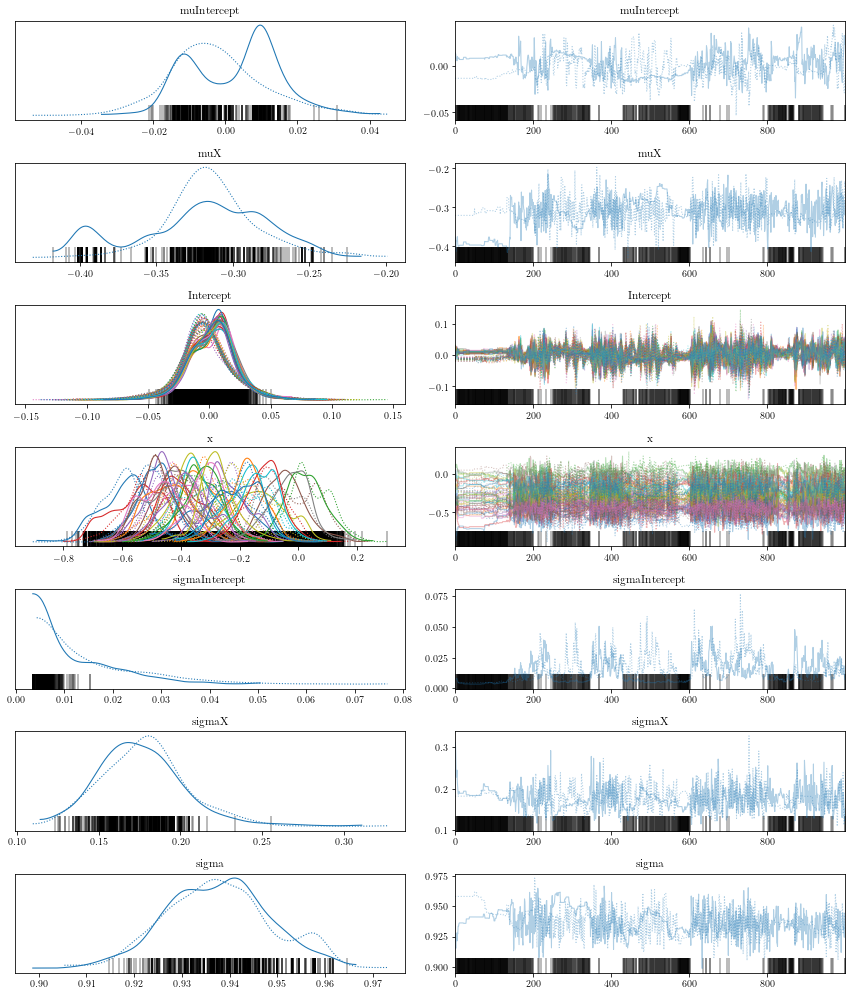

In [130]:
plt.figure(figsize=(7, 7))
pm.traceplot(burned_trace_hier)
plt.tight_layout();

In [131]:
rhats_params = az.rhat(burned_trace_hier, method="folded")
rhats_params

<xarray.Dataset>
Dimensions:          (Intercept_dim_0: 31, x_dim_0: 31)
Coordinates:
  * Intercept_dim_0  (Intercept_dim_0) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30
  * x_dim_0          (x_dim_0) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
Data variables:
    muIntercept      float64 1.015
    muX              float64 1.056
    Intercept        (Intercept_dim_0) float64 1.002 1.015 ... 1.004 1.008
    x                (x_dim_0) float64 1.002 1.007 1.014 ... 1.03 1.029 1.029
    sigmaIntercept   float64 0.9996
    sigmaX           float64 1.003
    sigma            float64 1.011

## check convergence: rhat<1.05 indicates good convergence

In [132]:
az.summary(burned_trace_hier, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
muIntercept,0.0002,0.0132,-0.0245,0.0242,0.0017,0.0012,59.7531,59.7531,63.6214,427.9053,1.0276
muX,-0.3165,0.0372,-0.3989,-0.2545,0.0071,0.0055,27.6357,23.5191,41.5283,17.2204,1.0563
Intercept[0],-0.0008,0.0205,-0.0369,0.0405,0.0017,0.0012,142.0213,142.0213,111.2958,720.2696,1.0119
Intercept[1],0.0001,0.0197,-0.0363,0.0401,0.0015,0.0011,170.5742,170.5742,124.0812,464.3460,1.0147
Intercept[2],-0.0000,0.0200,-0.0327,0.0460,0.0016,0.0011,165.3931,165.3931,122.4110,382.3996,1.0141
Intercept[3],0.0005,0.0200,-0.0339,0.0400,0.0015,0.0011,171.0647,171.0647,122.7844,608.8879,1.0130
Intercept[4],0.0007,0.0205,-0.0382,0.0422,0.0016,0.0011,168.9922,168.9922,121.9533,543.5908,1.0183
Intercept[5],-0.0006,0.0204,-0.0401,0.0400,0.0016,0.0011,158.7008,158.7008,115.2450,369.5647,1.0143
Intercept[6],0.0003,0.0200,-0.0407,0.0365,0.0016,0.0011,153.8058,153.8058,110.3617,479.8186,1.0123
Intercept[7],-0.0005,0.0203,-0.0367,0.0426,0.0014,0.0010,197.3242,197.3242,130.4222,417.5682,1.0128


## model estimator (for model comparison)

In [133]:
pm.waic(burned_trace_hier)
waic_hier = pm.waic(burned_trace_hier)

In [134]:
pm.loo(burned_trace_hier)

Computed from 2000 by 3720 log-likelihood matrix

         Estimate       SE
elpd_loo -5048.37    60.44
p_loo       33.04        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## generate samples from the posterior

In [135]:
ppc = pm.sample_posterior_predictive(trace, samples=2000, model=model,var_names = ['x','y','Intercept','sigma'])              #var_names = ['choice]) 

## show relationship data and posterior samples

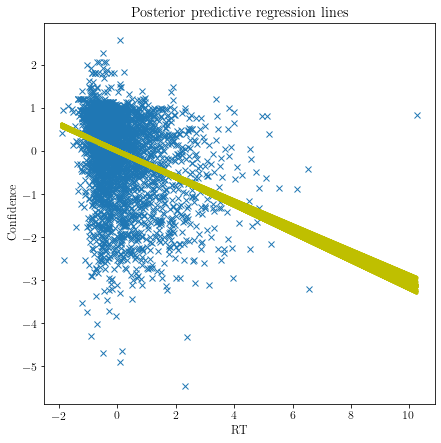

In [136]:
ppc = pm.sample_posterior_predictive(burned_trace2, samples=50, model=model2,var_names = ['Intercept','rt','Intercept','sd'])              #var_names = ['choice]) 

plt.figure(figsize=(7, 7))
plt.plot(rtByPart, confByPart, "x", label="data")
#pm.plot_posterior_predictive_glm(trace2, samples=100, label="posterior predictive regression lines")
for i in range(len(ppc['rt'])):
    plt.plot(rtByPart, ppc['rt'][i]*rtByPart + ppc['Intercept'][i] , label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
#plt.legend(loc=0)
plt.xlabel("RT")
plt.ylabel("Confidence");

# 5. Model comparison -- pooled vs hierarchical

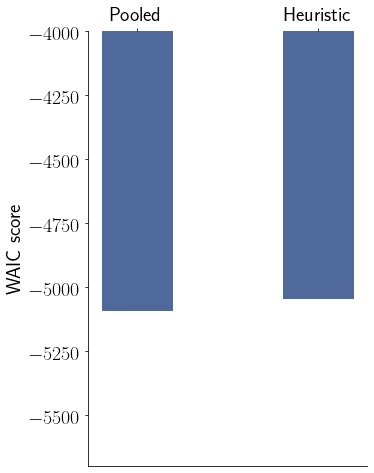

In [137]:
ysize = 20
ticksize = 20
nticks = 7

fig, ax = plt.subplots(1,1,figsize=(5,8))
sns.set(style='white', font_scale=1.8)

ax.set_facecolor('xkcd:white')
width_bars = 0.4
bars1 = plt.bar([0,1],[ waic1[0], waic_hier[0]], color='#4F6A9A',width = width_bars, hatch = '')

#patterns = ('', '')
plt.ylim(-5700,-4000)
plt.ylabel('WAIC score',fontsize = ysize )
    
# Turn off tick labels
plt.xticks([0,1],['Pooled','Heuristic'],fontsize = 20)
plt.axhline(0, color='black', lw=2, alpha=0.5)
plt.yticks(fontsize=ticksize)
ax.yaxis.set_major_locator(plt.MaxNLocator(nticks))
ax.xaxis.tick_top()

sns.despine()

plt.show()


 ------------------------------

# Additional model: fit to choice

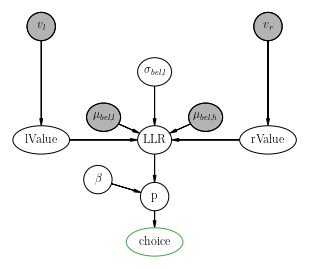

In [11]:
import daft
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

# generate nodes for the graphical representation

pgm = daft.PGM()

s_color = {"ec": "#46a546"}

pgm.add_node("lValue", r"lValue", -0.5, 3, aspect=2)
pgm.add_node("rValue", r"rValue", 3.5, 3, aspect=2)
pgm.add_node("sigmaGen1", r"$\sigma_{bel,l}$", 1.5, 4.2, aspect=1.2)
#pgm.add_node("sigmaGen2", r"$\sigma_{bel,h}$", 1.8, 4.2, aspect=1.2)
pgm.add_node("mu1", r"$\mu_{bel,l}$", 0.6, 3.4, aspect=1.2,observed = True)
pgm.add_node("mu2", r"$\mu_{bel,h}$", 2.4, 3.4, aspect=1.2,observed = True)
pgm.add_node("vl", r"$v_l$", -0.5, 5, aspect=1,observed = True)
pgm.add_node("vr", r"$v_r$", 3.5, 5, aspect=1,observed = True)
pgm.add_node("LLR", r"LLR", 1.5, 3, aspect=1.2)
pgm.add_node("b", r"$\beta$", 0.5, 2.3, aspect=1)
pgm.add_node("p", r"p", 1.5, 2, aspect=1)
pgm.add_node("choice", r"choice", 1.5, 1.2, aspect=2,plot_params=s_color)


# add edges to the graphical model 
pgm.add_edge("vl", "lValue", xoffset=-0.1)
pgm.add_edge("vr", "rValue", xoffset=-0.1)
pgm.add_edge("mu1", "LLR", xoffset=-0.1)
pgm.add_edge("mu2", "LLR", xoffset=-0.1)
pgm.add_edge("sigmaGen1", "LLR", xoffset=-0.1)
#pgm.add_edge("sigmaGen2", "LLR", xoffset=-0.1)
pgm.add_edge("rValue", "LLR", xoffset=-0.1)
pgm.add_edge("lValue", "LLR", xoffset=-0.1)
pgm.add_edge("LLR", "p", xoffset=-0.1)
pgm.add_edge("b", "p", xoffset=-0.1)
pgm.add_edge("p", "choice", xoffset=-0.1)



pgm.render()
#pgm.savefig("XX.pdf")
#pgm.savefig("PEB_BasicModel_2GenVariance_choice_new.png", dpi=200)


## Extract relevant constant for this model

mean values -> high: 0.8115919288920124 ,  low:-0.8110766237123309
stdev values -> high: 0.6723780146253707 ,  low:0.48162916118718574


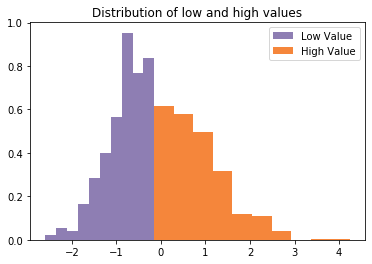

In [7]:
value_sort = val_a.copy()
value_sort.sort()
value_low = value_sort[:int(len(value_sort)/2)]
value_high = value_sort[int(len(value_sort)/2) + 1 :]

plt.title(r"Distribution of low and high values")
figsize(7, 7)
plt.hist(value_low, bins=10, alpha=0.85,
             label=r"Low Value", color="#7A68A6", normed=True)
plt.hist(value_high, bins=10, alpha=0.85,
             label=r"High Value", color="#F47118", normed=True)
plt.legend()

print ('mean values -> high: '+ str(value_high.mean()) +' ,  low:'+ str(value_low.mean()))
print ('stdev values -> high: '+ str(value_high.std()) +' ,  low:'+ str(value_low.std()))

n_trials = len(val_a)
mu = [value_low.mean(), value_high.mean()]

In [8]:
val_a

array([-0.89873549,  1.13613732, -0.89873549, ..., -1.5980889 ,
        0.86050941, -0.67611453])

In [9]:
value_sort

array([-2.59446284, -2.59446284, -2.54253641, ...,  3.51678506,
        4.2381639 ,  4.2381639 ])

## Version 1

In [10]:
with pm.Model() as model_choice1:
    # get value for each trial, generate sample for each 
    sigmaBel = pm.Uniform('sigmaBel', lower=0.5, upper=5) # low value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)

    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta = pm.Normal("beta", mu=0, sigma=0.001, testval = 0)
   # alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR)))    
    
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    conf = pm.Deterministic('conf',abs(LLR))   
    
    #start = pm.find_MAP()
    step1 = pm.Metropolis()
    
    nchains = 4
    trace_choice1 = pm.sample(3000, step =step1 ,chains= nchains)
    burned_trace_choice1 = trace_choice1[1000::2]    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [rVal]
>Metropolis: [lVal]
>Metropolis: [sigmaSamp]
>Metropolis: [sigmaBel]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 27 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
az.summary(burned_trace_choice1, round_to=4,var_names=["beta",'sigmaBel','sigmaSamp'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,-0.0072,0.0010,-0.0091,-0.0055,0.0000,0.0000,954.9481,954.9481,953.2702,974.0741,1.0064
sigmaBel,0.5050,0.0052,0.5000,0.5141,0.0001,0.0001,1825.0496,1825.0496,1365.2470,1190.3048,1.0027
sigmaSamp,0.5001,0.0001,0.5000,0.5003,0.0000,0.0000,1448.7875,1448.7875,1337.5780,1487.2871,1.0084


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa18b659c88>,
      dtype=object)

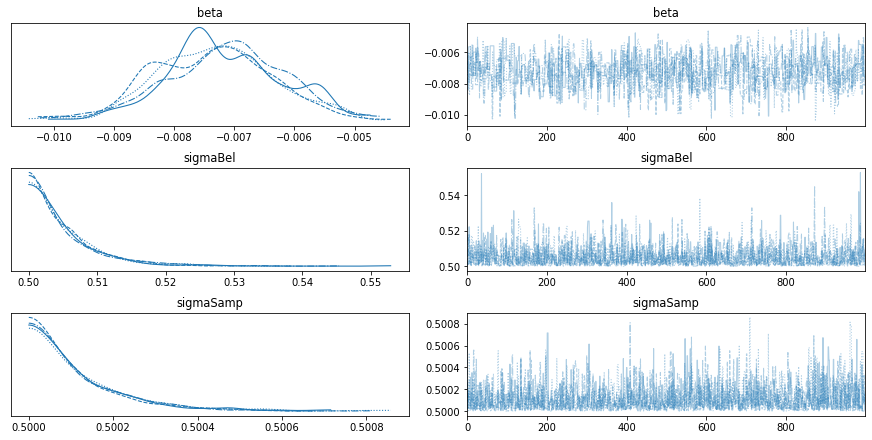

In [12]:
pm.traceplot(burned_trace_choice1, var_names=["beta",'sigmaBel','sigmaSamp'] )

Slope Coef [[0.0427672]]
Slope coef [[0.83648292]]
Slope Coef [[0.83648292]]


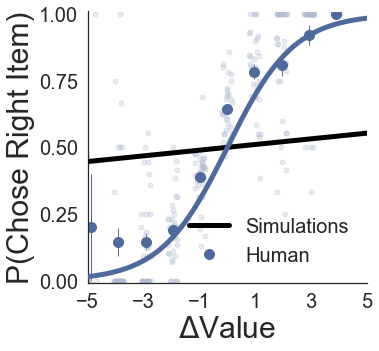

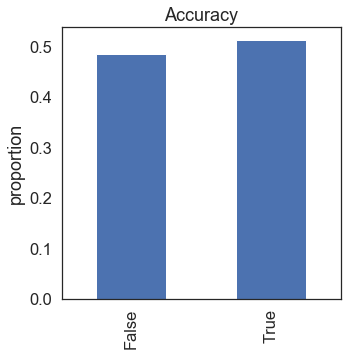

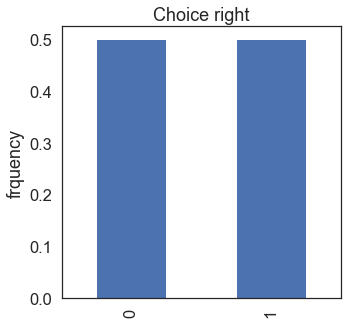

In [18]:
simHumanBehavPlots (burned_trace_choice1, model_choice1,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [19]:
pm.waic(burned_trace_choice1)
waic_choice1 = pm.waic(burned_trace_choice1)
waic_choice1

Computed from 4000 by 3720 log-likelihood matrix

          Estimate       SE
elpd_waic -2523.98     1.78
p_waic        0.38        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

# Version 2

In [8]:
with pm.Model() as model_choice2:
# get value for each trial, generate sample for each 
    sigmaBel = pm.Uniform('sigmaBel', lower=0.5, upper=5) # low value distribution
    sigmaSamp = pm.Uniform('sigmaSamp', lower=0.5, upper=5)
    
    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
    
    choice = pm.Bernoulli("choice", p, observed=chosenByPart)

    start = pm.find_MAP()
    step = pm.Metropolis()
    nchains = 4
    trace_choice2 = pm.sample(3000, step =step ,chains= nchains)
    burned_trace_choice2 = trace_choice2[1000::2]    



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [rVal]
>Metropolis: [lVal]
>Metropolis: [sigmaSamp]
>Metropolis: [sigmaBel]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
az.summary(burned_trace_choice2, round_to=4,var_names=["beta",'sigmaBel','sigmaSamp'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,-5.0039,3.5774,-11.6918,-0.5517,1.6475,1.2458,4.7149,4.7149,4.8650,15.4016,2.4761
sigmaBel,2.8527,1.1654,1.0427,4.7313,0.5416,0.4100,4.6306,4.6306,4.8475,15.9079,2.4884
sigmaSamp,0.5001,0.0001,0.5000,0.5003,0.0000,0.0000,1856.0725,1856.0725,1364.1114,1213.3300,1.0015


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce0cbf4550>,
      dtype=object)

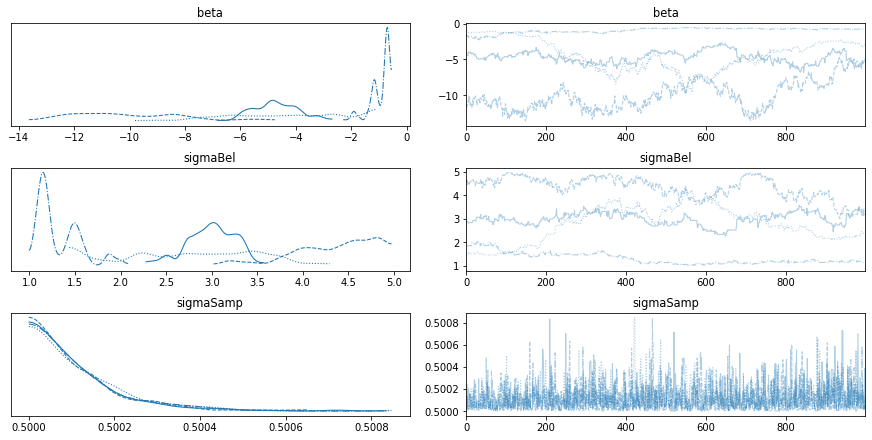

In [10]:
pm.traceplot(burned_trace_choice2, var_names=["beta",'sigmaBel','sigmaSamp'] )

Slope Coef [[0.83408203]]
Slope coef [[0.83648292]]
Slope Coef [[0.83648292]]


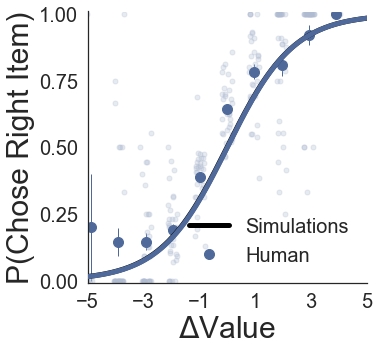

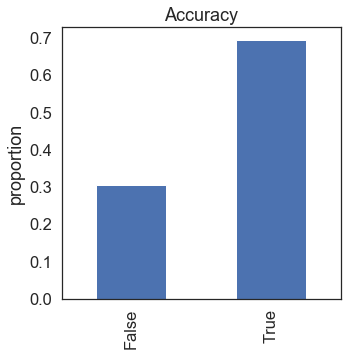

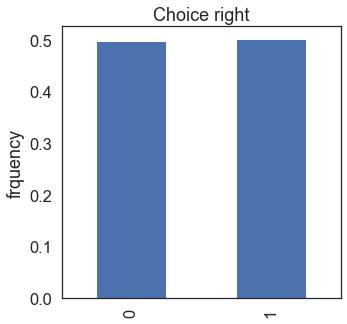

In [16]:
simHumanBehavPlots (burned_trace_choice2, model_choice2,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [17]:
pm.waic(burned_trace_choice2)
waic_choice2 = pm.waic(burned_trace_choice2)
waic_choice2

Computed from 4000 by 3720 log-likelihood matrix

          Estimate       SE
elpd_waic -2118.63    27.87
p_waic       78.31        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

# Simulations v2

In [18]:
ppc = pm.sample_posterior_predictive(burned_trace_choice2, samples = 2000, model = model_choice2,var_names = ['sigmaBel','sigmaSamp','beta'])              #var_names = ['choice]) 

In [19]:
sigmaBel_fit_mean = ppc['sigmaBel'].mean()  
sigmaSamp_fit_mean = ppc['sigmaSamp'].mean()  
beta_fit_mean = ppc['beta'].mean()  

sigmaBel_fit_sd = ppc['sigmaBel'].std()  
sigmaSamp_fit_sd = ppc['sigmaSamp'].std()  
beta_fit_sd = ppc['beta'].std()  

In [20]:
beta_fit_mean

-4.533533869810843

In [21]:
beta_fit_sd

1.6402704496465037

In [22]:
with pm.Model() as model_sims:
# get value for each trial, generate sample for each 
    sigmaBel =  pm.Normal("sigmaBel", mu=sigmaBel_fit_mean, sigma=sigmaBel_fit_sd)
    sigmaSamp =  pm.Normal("sigmaSamp", mu=sigmaSamp_fit_mean, sigma=sigmaSamp_fit_sd)
    
    lVal = pm.Normal('lVal', mu = val_a, sigma = sigmaSamp , shape = n_trials)
    rVal = pm.Normal('rVal', mu = val_b, sigma = sigmaSamp  , shape = n_trials)
    
    # estimate odds ratio for the choice of right option
    
    LLR = pm.Deterministic('LLR',  tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.)))) - 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(rVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) + 
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[0] , 2.) / (2 * tt.power(sigmaBel, 2.)))) -
                                   tt.log(1/(sigmaBel * tt.sqrt(2 * np.pi))*tt.exp(-tt.power(lVal - mu[1] , 2.) / (2 * tt.power(sigmaBel, 2.))))  )

    beta =     pm.Normal("beta", mu=beta_fit_mean, sigma=beta_fit_sd)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*LLR) ))    
    
    choice = pm.Bernoulli("choice", p, shape = n_trials)

    #start = pm.find_MAP()
    step = pm.Metropolis()
    #nchains = 4
    trace_choice_sims = pm.sample(1000, step = step)
    #burned_trace_choice2 = trace_choice2[1000::2]    



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [choice]
>Metropolis: [beta]
>Metropolis: [rVal]
>Metropolis: [lVal]
>Metropolis: [sigmaSamp]
>Metropolis: [sigmaBel]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Slope Coef [[87.05897938]]
Slope coef [[0.83648292]]
Slope Coef [[0.83648292]]


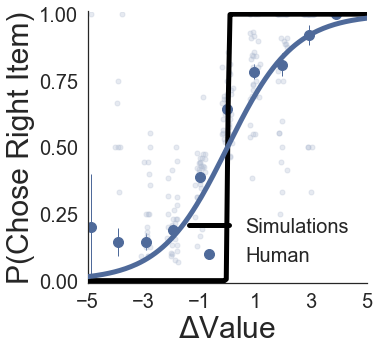

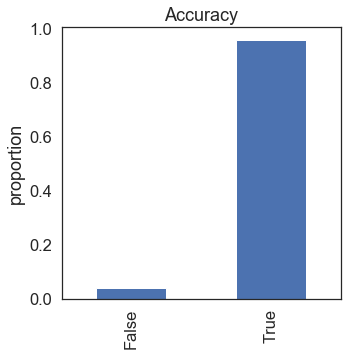

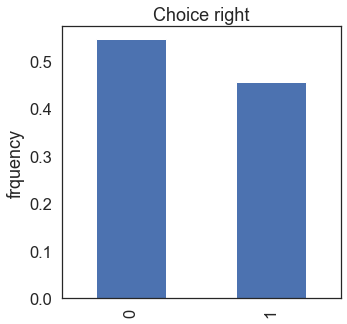

In [23]:
simHumanBehavPlots (trace_choice_sims, model_sims,data_part_all,colorP = ['#4F6A9A','#AFBBD1'])

In [29]:
ppc = pm.sample_posterior_predictive(trace_choice_sims, samples = 10, model = model_sims,var_names = ['p','choice'])              #var_names = ['choice]) 

In [30]:
ppc['p']

array([[9.72486877e-03, 5.00750917e-05, 1.00000000e+00, ...,
        9.97366844e-02, 1.64490161e-01, 1.00000000e+00],
       [1.09135844e-02, 6.21077582e-05, 1.00000000e+00, ...,
        1.19733495e-01, 1.84819171e-01, 1.00000000e+00],
       [1.35973748e-02, 1.06579285e-04, 1.00000000e+00, ...,
        1.35180491e-01, 2.03416872e-01, 1.00000000e+00],
       ...,
       [1.99915816e-02, 2.06896431e-04, 1.00000000e+00, ...,
        1.87511406e-01, 1.98059488e-01, 1.00000000e+00],
       [1.99915816e-02, 2.06896431e-04, 1.00000000e+00, ...,
        1.87511406e-01, 1.98059488e-01, 1.00000000e+00],
       [1.81735989e-02, 2.40175594e-04, 1.00000000e+00, ...,
        1.79174842e-01, 1.96905856e-01, 1.00000000e+00]])

In [31]:
ppc['choice']

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1]])

In [32]:
val_b - val_a

array([-3.39145469e-01, -6.78290938e-01,  2.71316375e+00, ...,
       -5.12207981e-02, -7.77156117e-16,  1.38296155e+00])

Slope Coef [[87.04501921]]


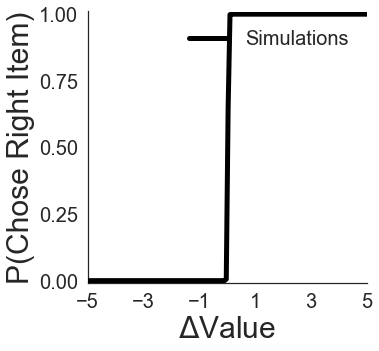

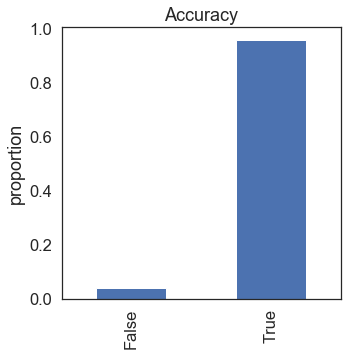

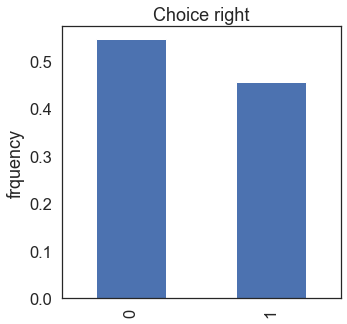

In [33]:
ppc = pm.sample_posterior_predictive(trace_choice_sims, samples=10, model=model_sims,var_names = ['choice']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

posterior_df = pd.DataFrame()
posterior_df['choice'] = ppc['choice'].flatten()
posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
posterior_df['correct'] = RbiggerL == posterior_df['choice']


## FIGURE
logisticplot_simpl ('Simulations', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                  modlowcol='#000000', title='empty',xlim = [-5,5])


plt.show()

    # FIGURE
posterior_df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
plt.ylabel('proportion')
plt.show()

posterior_df['choice'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Choice right')
plt.ylabel('frquency')
plt.show()


# Appendix - extra functions

In [14]:
def simHumanBehavPlots (burned_trace, model_peb1,data_part_all_test,colorP = ['#4F6A9A','#AFBBD1']):

    ppc = pm.sample_posterior_predictive(burned_trace, samples=50, model=model_peb1,var_names = ['choice']) # generates samples from the posterior, im this case the samples consider the 120 trials inputs

    posterior_df = pd.DataFrame()
    posterior_df['choice'] = ppc['choice'].flatten()
    posterior_df['lValue'] = np.tile(val_a, len(ppc['choice']))
    posterior_df['rValue'] = np.tile(val_b, len(ppc['choice']))
    posterior_df['dValue'] = np.tile(val_b - val_a, len(ppc['choice']))
    posterior_df['sumValue'] = np.tile(val_b + val_a, len(ppc['choice']))
    posterior_df['absDValue'] = np.tile(np.abs(val_b - val_a), len(ppc['choice']))
    RbiggerL = np.tile((val_b>val_a), len(ppc['choice']))
    posterior_df['correct'] = RbiggerL == posterior_df['choice']
    
    data_part = pd.DataFrame()    
    data_part['choice'] = data_part_all_test.ChosenITM
    data_part['dValue'] = data_part_all_test.zRValue - data_part_all_test.zLValue 
    # z-score participant
    data_part['zAbsDValue'] =  data_part_all_test.zAbsDV.values
    data_part['zSumValue'] = data_part_all_test.zTotVal.values
    # add chosen and unchosen
    data_part['Part'] = data_part_all_test.Part
    
    ## FIGURE
    logisticplot_simpl ('Simulations', posterior_df, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol='#000000', title='empty',xlim = [-5,5])
    
    logisticplot_simplDots ('Human', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                            meanCol=colorP[0], subjCol = colorP[1], title='empty',xlim = [-5,5])
    
    logisticplot_simpl ('', data_part, xaxis='dValue', yaxis='choice', ylab='P(Chose Right Item)', xlab='$\Delta$Value',
                      modlowcol=colorP[0], title='empty', linewidth = 3 ,xlim = [-5,5])
    
    plt.show()
    
        # FIGURE
    posterior_df['correct'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Accuracy')
    plt.ylabel('proportion')
    plt.show()
    
    posterior_df['choice'].value_counts(normalize=1,sort=0).plot(kind='bar',title='Choice right')
    plt.ylabel('frquency')
    plt.show()


In [15]:
def logisticplot_simpl (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  modlowcol='#AAAAAA', title='empty', xlim = [-5,5],linewidth = 5):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Slope Coef',clf.coef_)
    
    #Plotting the predictive lines
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

In [16]:
def logisticplot_simplDots (modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                  meanCol='#AAAAAA',subjCol='#000000', title='empty', xlim = [-5,5]):
    
    sns.set(font_scale=1.5, style='white')
    figsize(5,5)
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    logit_low = {}

    # I think this defines the problem space
    X_test = np.linspace(-10,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data[xaxis][:, np.newaxis],
            data [yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Slope coef',clf.coef_)
    
    #      data.groupby(['Part', 'difficulty']).choice.mean()

    
    # generate scatter to plot pariticipants means
    
    levels =  (np.max(data[xaxis]) - np.min(data[xaxis]))/10
    lev_label = np.arange(np.min(data[xaxis]), np.max(data[xaxis]) + levels,levels) 
    
    difficulty2= []
    for i in range(len(data[xaxis].values)):
         difficulty2.append( lev_label[ int((data[xaxis].values[i] - np.min(data[xaxis]) )//levels)] )
            
    data['difficulty'] = np.around(difficulty2, decimals = 3)        
    
    subject_means = data.groupby(['Part', 'difficulty']).choice.mean()
    means = subject_means.groupby('difficulty').mean()
    sems = subject_means.groupby('difficulty').sem()
    
    #Plotting the predictive lines
    #line_low = sub.scatter(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 

    # plot subject means
    scatter_data = subject_means.reset_index()
    x_scatter = scatter_data['difficulty'] 
    jittr = np.random.uniform(low=-max(x_scatter)/10,high=max(x_scatter)/10,size=len(scatter_data))/2
    sub.plot(x_scatter+jittr, scatter_data.choice.values, marker='o', ms=5, markerfacecolor=subjCol, color=subjCol,alpha=0.3,linestyle="None")

    # plot mean values
    sub.plot(list(means.index), means.values, 'o', markerfacecolor=meanCol, markersize = 10, fillstyle = 'full',
                    color=meanCol, linewidth=1,label=modlow)
    sub.vlines(list(means.index), means - sems, means + sems,
                      linewidth=1, color= meanCol)
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    #sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(xlim[0], xlim[1])

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(frameon=False, prop={'size':20})
    
    sns.despine()

# --------------- END --------------------------